### Business questions: 

For someone considering switching careers to programming or just starting in the field, it might be interesting to get an idea of how it would influence their life and how it would fit their personality. I would like to investigate the following three questions:

* What are typical lifestyles among the developers?

* How supportive or tight is the community?

* What are the job priorities that make programmers happy?

### Data understanding

#### Gather

To answer these questions I got the data from [stackoverflow](https://insights.stackoverflow.com/survey). 

### Data preparation

#### Assess

This might also be considered a part of data understanding. 

Having reviewed the data I decided to use 'YearsCodingProf', 'CareerSatisfaction', 'WakeTime', 'HoursComputer', 'HoursOutside', 'SkipMeals', 'Exercise' to answer the first question. For the second question I will use the three AgreeDisagree columns describing whether or not respondents 'feel_kinship', 'feel_competitive', 'feel_less_skilled' compared to their colleagues as well as 'YearsCodingProf', 'CareerSatisfaction'. And for the this question I will use the ten AssessJob columns corresponding to job priorities together with 'CareerSatisfaction' and salary information. 


#### Clean

We will have to do some cleaning of the data before we proceed. I will mark these bits with comments below. 

### Model

#### Analyze, model, visualize
For the first question we will perform kmeans clustering. For the other two questions we will use tables and visuals to draw conclustions. 

### Evaluate the results

We will evaluate the result and report on them in [this blog post](https://medium.com/@anamamatelashvili/are-programmers-really-geeky-hermits-f3fd9e432175). 

### Deploy

There is no deployment necessary for these questions. 

Let's start with imports and loading data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore') # to ignore mixed dtypes warning when loading the data

In [2]:
df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
schema = schema.set_index('Column')

## What are typical lifestyles among the developers?

We start by cleaning up columns for job satisfaction and years of professional coding and turn them into numeric columns. 

The plan is to use kmeans clustering to identify typical behaviours of developers. Several of the variables we will be using are ordinal variables, so it makes sense to assign reasonable numerical values for kmeans clustering. 

In [3]:
# clean CareerSatisfaction
df.CareerSatisfaction = df.CareerSatisfaction.replace({'Extremely satisfied':3, 
                               'Moderately satisfied':2, 
                               'Slightly satisfied':1, 
                               'Neither satisfied nor dissatisfied':0,
                               'Slightly dissatisfied':-1,
                               'Moderately dissatisfied':-2,
                               'Extremely dissatisfied':-3})

# clean YearsCodingProf
df.YearsCodingProf = df.YearsCodingProf.replace({'3-5 years':4, 
                                                 '18-20 years':19, 
                                                 '6-8 years':7, 
                                                 '12-14 years':13,
                                                 '0-2 years':1, 
                                                 '21-23 years':22, 
                                                 '24-26 years':25, 
                                                 '9-11 years':10,
                                                 '15-17 years':16, 
                                                 '27-29 years':28, 
                                                 '30 or more years':30})

In [4]:
df_lifestyle = df[['YearsCodingProf', 'CareerSatisfaction', 'WakeTime', 'HoursComputer', 'HoursOutside',
                   'SkipMeals', 'Exercise']].copy()
df_lifestyle.head()

,YearsCodingProf,CareerSatisfaction,WakeTime,HoursComputer,HoursOutside,SkipMeals,Exercise
0,4.0,3.0,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,3 - 4 times per week
1,19.0,0.0,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,Never,Daily or almost every day
2,7.0,2.0,NaN,NaN,NaN,NaN,NaN
3,13.0,-1.0,Between 6:01 - 7:00 AM,9 - 12 hours,Less than 30 minutes,3 - 4 times per week,I don't typically exercise
4,1.0,2.0,Before 5:00 AM,Over 12 hours,1 - 2 hours,Never,3 - 4 times per week


In [5]:
# clean
wake_time_dict = {'Between 5:00 - 6:00 AM':5.5, 'Between 6:01 - 7:00 AM':6.5, 
       'Before 5:00 AM':4, 'Between 7:01 - 8:00 AM':7.5,
       'Between 9:01 - 10:00 AM':9.5, 'I do not have a set schedule':np.nan,
       'Between 8:01 - 9:00 AM':8.5, 'Between 10:01 - 11:00 AM':10.5,
       'Between 11:01 AM - 12:00 PM':11.5, 'After 12:01 PM':13,
       'I work night shifts':22}
hours_comp_dict = {'9 - 12 hours':10.5, '5 - 8 hours':6.5, 'Over 12 hours':13, 
                   '1 - 4 hours':2.5, 'Less than 1 hour':.5}
hours_out_dict = {'1 - 2 hours':1.5, '30 - 59 minutes':.75, 'Less than 30 minutes':.25,
       '3 - 4 hours':3.5, 'Over 4 hours':5}
skip_meals_dict = {'Never':0, '3 - 4 times per week':3.5, '1 - 2 times per week':1.5,
       'Daily or almost every day':7}
exercise_dict = {'3 - 4 times per week':3.5, 'Daily or almost every day':7, 
       "I don't typically exercise":0, '1 - 2 times per week':1.5}

df_lifestyle.WakeTime = df_lifestyle.WakeTime.replace(wake_time_dict, regex=True)
df_lifestyle.HoursComputer = df_lifestyle.HoursComputer.replace(hours_comp_dict, regex=True)
df_lifestyle.HoursOutside = df_lifestyle.HoursOutside.replace(hours_out_dict, regex=True)
df_lifestyle.SkipMeals = df_lifestyle.SkipMeals.replace(skip_meals_dict, regex=True)
df_lifestyle.Exercise = df_lifestyle.Exercise.replace(exercise_dict, regex=True)

df_lifestyle.head()

,YearsCodingProf,CareerSatisfaction,WakeTime,HoursComputer,HoursOutside,SkipMeals,Exercise
0,4.0,3.0,5.5,10.5,1.50,0.0,3.5
1,19.0,0.0,6.5,6.5,0.75,0.0,7.0
2,7.0,2.0,NaN,NaN,NaN,NaN,NaN
3,13.0,-1.0,6.5,10.5,0.25,3.5,0.0
4,1.0,2.0,4.0,13.0,1.50,0.0,3.5


Next we fill the missing values with means. This approach makes sense because we are looking for average trends in the data. As we plan on using a clustering algorithm we also need to scale the data to make sure we do not favor any of the features. 

In [6]:
imputer = Imputer(strategy='mean')
df_imputed = imputer.fit_transform(df_lifestyle)
df_imputed = pd.DataFrame(df_imputed, index=df_lifestyle.index, columns=df_lifestyle.columns)

scaler = StandardScaler()
scaler.fit(df_imputed)
df_scaled = pd.DataFrame(scaler.transform(df_imputed), index=df_lifestyle.index, columns=df_lifestyle.columns)

#### Analyze

We will consider kmeans algorithm with several different cluster numbers to decide which number of clusters seems the most appropriate. As we visualise average squared distance from centroids vs. number of clusters we see that there is an elbow at 8 clusters. 

Running kmeans with 2 clusters...
Score: 6

Running kmeans with 3 clusters...
Score: 6

Running kmeans with 4 clusters...
Score: 5

Running kmeans with 5 clusters...
Score: 5

Running kmeans with 6 clusters...
Score: 4

Running kmeans with 7 clusters...
Score: 4

Running kmeans with 8 clusters...
Score: 3

Running kmeans with 9 clusters...
Score: 3

Running kmeans with 10 clusters...
Score: 3

Running kmeans with 11 clusters...
Score: 3

Running kmeans with 12 clusters...
Score: 3

Running kmeans with 13 clusters...
Score: 3

Running kmeans with 14 clusters...
Score: 3

Running kmeans with 15 clusters...
Score: 3

Running kmeans with 16 clusters...
Score: 3

Running kmeans with 17 clusters...
Score: 3

Running kmeans with 18 clusters...
Score: 3

Running kmeans with 19 clusters...
Score: 2

Running kmeans with 20 clusters...
Score: 2



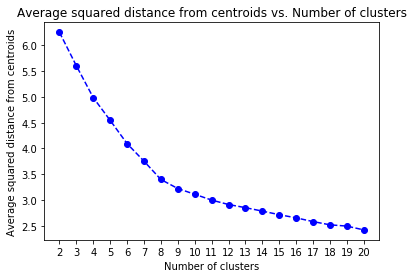

In [7]:
scores=[]
for i in range(2,21):
    print('Running kmeans with {} clusters...'.format(i))
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=2)
    kmeans.fit(df_scaled)
    
    # compute the average within-cluster distances.
    score = kmeans.inertia_ / df_scaled.shape[0]
    scores.append(score)
    print("Score: {:.0f}\n".format(score))
        
plt.plot(range(2,21), scores, linestyle='--', marker='o', color='b')
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('Number of clusters')
plt.ylabel('Average squared distance from centroids')
plt.title('Average squared distance from centroids vs. Number of clusters');

#### Model
Next we use kmeans clustering with 8 clusters to identify typical lifestyles. 

In [8]:
# model
kmeans_8 = KMeans(n_clusters=8, random_state=2)
kmeans_8.fit(df_scaled)
clusters = kmeans_8.predict(df_scaled)
clusters = pd.Series(clusters, name='Cluster_labels', index=df_scaled.index)
cluster_counts = clusters.value_counts()

centers = kmeans_8.cluster_centers_
centers = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(np.round(centers), columns=df_scaled.columns)

centers_df['counts'] = cluster_counts
centers_df

,YearsCodingProf,CareerSatisfaction,WakeTime,HoursComputer,HoursOutside,SkipMeals,Exercise,counts
0,6.0,2.0,7.0,10.0,1.0,1.0,2.0,46017
1,21.0,2.0,7.0,9.0,1.0,1.0,2.0,7833
2,7.0,1.0,7.0,10.0,1.0,7.0,2.0,3611
3,5.0,-1.0,7.0,10.0,1.0,1.0,1.0,13159
4,6.0,1.0,7.0,9.0,2.0,1.0,7.0,8188
5,5.0,1.0,7.0,9.0,4.0,1.0,2.0,6728
6,5.0,1.0,22.0,10.0,2.0,2.0,2.0,327
7,5.0,2.0,7.0,6.0,1.0,1.0,1.0,12992


#### Visualize
We will not use a visualisation for this conclusion, we will use the above and below tables to support our finding. 

In [9]:
df_lifestyle[df_lifestyle.YearsCodingProf < 4].mean()

YearsCodingProf       1.000000
CareerSatisfaction    0.988033
WakeTime              7.357356
HoursComputer         9.089740
HoursOutside          1.455960
SkipMeals             1.130924
Exercise              2.061919
dtype: float64

## How supportive or tight is the community?

In [10]:
df_comp = df[['AgreeDisagree1', 'AgreeDisagree2', 'AgreeDisagree3', 'YearsCodingProf', 'CareerSatisfaction']]
df_comp.columns = ['feel_kinship', 'feel_competitive', 'feel_less_skilled', 'YearsCodingProf', 'CareerSatisfaction']

# clean
df_comp = df_comp.replace({'Strongly agree':2,
                           'Agree':1,
                           'Neither Agree nor Disagree':0,
                           'Disagree':-1,
                           'Strongly disagree':-2})
df_comp.head()

,feel_kinship,feel_competitive,feel_less_skilled,YearsCodingProf,CareerSatisfaction
0,2.0,2.0,0.0,4.0,3.0
1,1.0,1.0,0.0,19.0,0.0
2,NaN,NaN,NaN,7.0,2.0
3,-1.0,-1.0,-2.0,13.0,-1.0
4,2.0,1.0,-2.0,1.0,2.0


#### Analyze, model, visualize
We will not need modeling for this question. Instead we will analyze means for various groups and make tables and visualisations. The nan values will be skipped in the mean calculations (default option), which makes sense since we are trying to get a general picture. 

In [11]:
df_comp.groupby('YearsCodingProf').mean().style.bar(subset=['feel_kinship', 
                                                            'feel_competitive', 
                                                            'feel_less_skilled', 
                                                            'CareerSatisfaction'],
                                                    align='mid', color=['#d65f5f', '#5fba7d'])

,feel_kinship,feel_competitive,feel_less_skilled,CareerSatisfaction
YearsCodingProf,,,,
1.0,0.750336,0.0445735,-0.259795,0.988033
4.0,0.775281,-0.00373499,-0.579129,1.16256
7.0,0.773737,-0.108975,-0.744094,1.24873
10.0,0.784296,-0.192219,-0.785901,1.19454
13.0,0.835426,-0.20929,-0.868232,1.17915
16.0,0.83572,-0.298193,-0.87712,1.2016
19.0,0.849428,-0.342002,-0.887618,1.24164
22.0,0.871605,-0.359967,-1.00412,1.2675
25.0,0.877395,-0.33461,-0.97449,1.30246


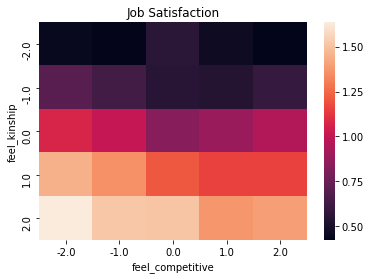

In [12]:
table = df_comp.groupby(['feel_kinship', 'feel_competitive']).CareerSatisfaction.mean().reset_index().pivot(index='feel_kinship', columns='feel_competitive', values='CareerSatisfaction')
fig = plt.figure()
ax = sns.heatmap(table)
ax.set_title('Job Satisfaction');
fig.savefig('heatmap.png')

## What are the job priorities that make programmers happy?


#### Clean, analyze, model, visualize
The ten 'AssessJob' columns for the job priorities and salary column do not need any extra cleaning and we have already cleaned the columns for job satisfaction and years of professional coding above.  

We will not need modeling for this questions. Instead we will analyze salary and job satisfaction for choices of job priority for all developers as well as early career developers.  

The nan values will be skipped in the mean calculations (default option), which makes sense since we are trying to get a general picture.

In [13]:
df_priorities = pd.DataFrame({'attribute' : schema.index[schema.index.str.contains('AssessJob')]})
df_priorities['priority'] = df_priorities.attribute.apply(lambda x: re.sub(string=schema.QuestionText[x], pattern=r'^.*\. ', repl=''))
df_priorities['counts'] = df_priorities.attribute.apply(lambda x: df[df[x] == 1].shape[0])
df_priorities['job_satisfaction'] = df_priorities.attribute.apply(lambda x: df.CareerSatisfaction[df[x] == 1].mean())
df_priorities['salary'] = df_priorities.attribute.apply(lambda x: df.ConvertedSalary[df[x] == 1].mean())
df_priorities['starting_job_satisfaction'] = df_priorities.attribute.apply(lambda x: df.CareerSatisfaction[(df[x] == 1) & (df['YearsCodingProf'] <= 2) & (df['YearsCodingProf'] > 0)].mean())
df_priorities['starting_career_salary'] = df_priorities.attribute.apply(lambda x: df.ConvertedSalary[(df[x] == 1) & (df['YearsCodingProf'] <= 2) & (df['YearsCodingProf'] > 0)].mean())

In [14]:
df_priorities[['priority', 
               'counts',
               'job_satisfaction', 
               'salary',
               'starting_job_satisfaction', 
               'starting_career_salary']].style.bar(subset=['counts',
                                                            'job_satisfaction',
                                                            'salary', 
                                                            'starting_job_satisfaction',
                                                            'starting_career_salary'], 
                                                    align='mid', color=['#d65f5f', '#5fba7d'])

,priority,counts,job_satisfaction,salary,starting_job_satisfaction,starting_career_salary
0,The industry that I'd be working in,4981,1.05222,83330.9,0.936674,56372.6
1,The financial performance or funding status of the company or organization,2301,0.967639,79665.3,0.719799,33788.7
2,The specific department or team I'd be working on,3694,1.2879,104440,1.13641,63470.5
3,"The languages, frameworks, and other technologies I'd be working with",11586,1.20298,86845.9,1.05304,46502.8
4,The compensation and benefits offered,12263,1.17807,114637,1.08365,84479.1
5,The office environment or company culture,9117,1.28657,93817,1.22218,68549.4
6,The opportunity to work from home/remotely,6872,1.12073,105676,0.867074,49166.3
7,Opportunities for professional development,10694,1.0645,80905.7,0.91511,52362
8,The diversity of the company or organization,1102,1.11409,96680.7,0.980556,69836.9
9,How widely used or impactful the product or service I'd be working on is,4375,1.20415,101081,1.01254,54270.8
